Colab Setup, Library Imports

In [3]:
from google.colab import drive

import pandas as pd
import numpy as np
import json
import re
import string
!pip install datasets
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load Both Datasets in Compatible Format

In [4]:
data1 = pd.read_csv('/content/drive/MyDrive/Machine Learning/data.csv')

data1.rename(columns={'text': 'Sentence', 'sentiment': 'Sentiment'}, inplace=True)
data1 = data1.dropna(subset=['Sentence'])

print("Dataset 1 Columns:", data1.columns.tolist())
ds = load_dataset("TimKoornstra/financial-tweets-sentiment")
data2_raw = ds['train'].to_pandas()

data2 = data2_raw.drop(columns=['url'])
data2.rename(columns={'tweet': 'Sentence', 'sentiment': 'Sentiment'}, inplace=True)
data2 = data2.dropna(subset=['Sentence', 'Sentiment'])

print("Dataset 2 Columns:", data2.columns.tolist())


Dataset 1 Columns: ['Sentence', 'Sentiment']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/38091 [00:00<?, ? examples/s]

Dataset 2 Columns: ['Sentence', 'Sentiment']


# Dataset 1

### Preprocessing Dataset 1

In [5]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
financial_stopwords = {'rt', 'via', 'amp', 'stock', 'stocks', 'market', 'markets'}

def preprocess_financial_text(text):

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)

    # Handle ticker symbols ($AAPL → aapl)
    text = re.sub(r'\$([a-zA-Z]+)', r'\1', text)

    # Handle percentages (25% → 25percent)
    text = re.sub(r'(\d+)%', r'\1percent', text)
    text = re.sub(r'[^\w\s.%$]', '', text)

    tokens = word_tokenize(text)
    cleaned = []

    for word in tokens:
        if word in stop_words or word in financial_stopwords or len(word) < 3:
            continue
        word = lemmatizer.lemmatize(word)

        # Keep words, numbers, and financial markers
        if word.isalpha() or word.isdigit() or 'percent' in word:
            cleaned.append(word)

    return ' '.join(cleaned)

print("Original data1 sample:")
print(data1[['Sentence']].head(3))

data1['Cleaned'] = data1['Sentence'].apply(preprocess_financial_text)

# Show before/after comparison
print("\nPreprocessed data1 sample:")
print(data1[['Sentence', 'Cleaned']].head(3))

# Calculate statistics
original_length = data1['Sentence'].apply(lambda x: len(word_tokenize(x))).mean()
cleaned_length = data1['Cleaned'].apply(lambda x: len(word_tokenize(x))).mean()
reduction_pct = (1 - cleaned_length/original_length) * 100

print(f"\nPreprocessing stats:")
print(f"Avg original length: {original_length:.1f} words")
print(f"Avg cleaned length: {cleaned_length:.1f} words")
print(f"Reduction: {reduction_pct:.1f}%")

# Check for empty results
empty_cleaned = data1[data1['Cleaned'].str.len() == 0]
print(f"\nFound {len(empty_cleaned)} empty results after cleaning")
if not empty_cleaned.empty:
    print("Sample affected rows:")
    print(empty_cleaned[['Sentence', 'Cleaned']].head(3))

Original data1 sample:
                                            Sentence
0  The GeoSolutions technology will leverage Bene...
1  $ESI on lows, down $1.50 to $2.50 BK a real po...
2  For the last quarter of 2010 , Componenta 's n...

Preprocessed data1 sample:
                                            Sentence  \
0  The GeoSolutions technology will leverage Bene...   
1  $ESI on lows, down $1.50 to $2.50 BK a real po...   
2  For the last quarter of 2010 , Componenta 's n...   

                                             Cleaned  
0  geosolutions technology leverage benefon gps s...  
1                           esi low real possibility  
2  last quarter 2010 componenta net sale doubled ...  

Preprocessing stats:
Avg original length: 21.6 words
Avg cleaned length: 11.0 words
Reduction: 48.8%

Found 1 empty results after cleaning
Sample affected rows:
        Sentence Cleaned
921  It 's not .        


## Analaysis

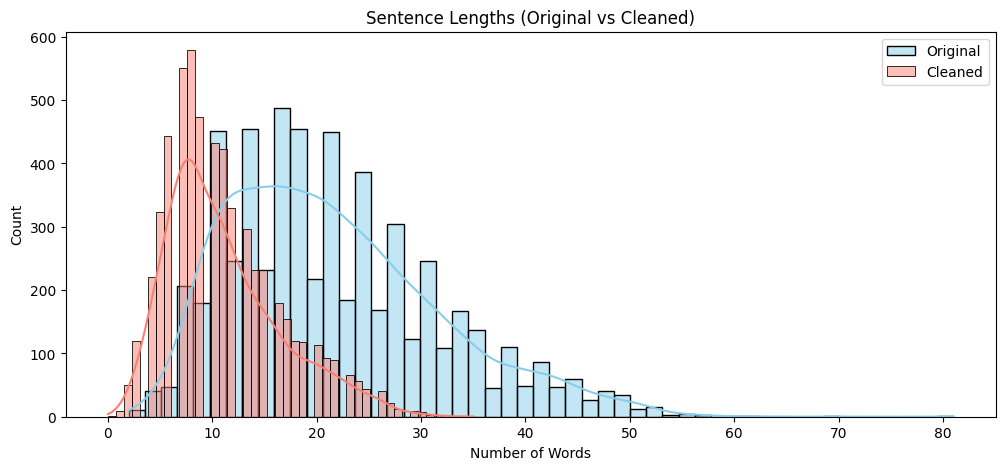

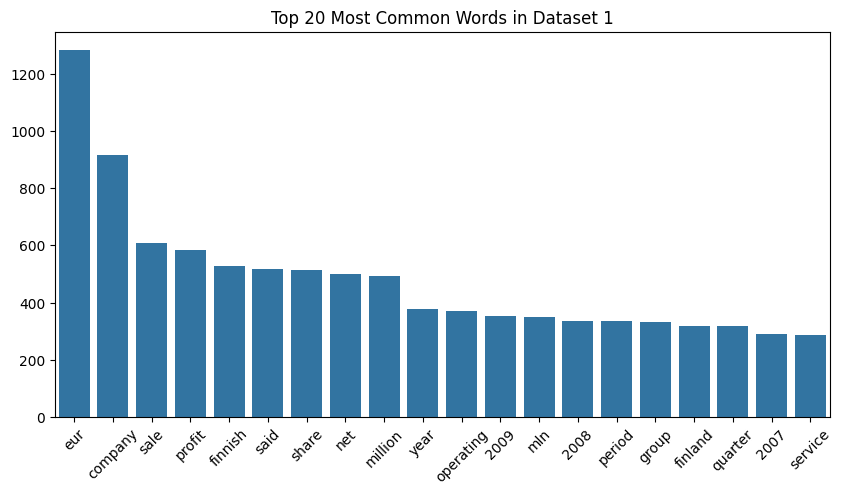

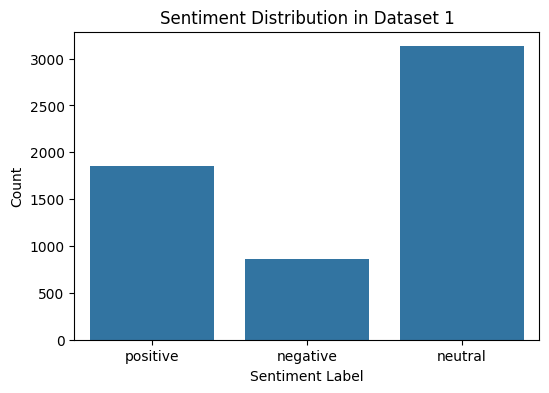

In [6]:
# Sentence lengths before and after preprocessing
data1['Original_Length'] = data1['Sentence'].apply(lambda x: len(word_tokenize(x)))
data1['Cleaned_Length'] = data1['Cleaned'].apply(lambda x: len(word_tokenize(x)))

# Plot sentence lengths
plt.figure(figsize=(12, 5))
sns.histplot(data1['Original_Length'], kde=True, color='skyblue', label='Original')
sns.histplot(data1['Cleaned_Length'], kde=True, color='salmon', label='Cleaned')
plt.title("Sentence Lengths (Original vs Cleaned)")
plt.xlabel("Number of Words")
plt.legend()
plt.show()

# Plot most common words
all_words = ' '.join(data1['Cleaned']).split()
word_freq = Counter(all_words).most_common(20)

plt.figure(figsize=(10, 5))
sns.barplot(x=[w[0] for w in word_freq], y=[w[1] for w in word_freq])
plt.title("Top 20 Most Common Words in Dataset 1")
plt.xticks(rotation=45)
plt.show()

# Sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Sentiment', data=data1)
plt.title("Sentiment Distribution in Dataset 1")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()


# Dataset 2

# Preprocessing

In [7]:
data2['Cleaned'] = data2['Sentence'].apply(preprocess_financial_text)

print("\n" + "="*80)
print("Dataset 2 Financial Text Preprocessing Results")
print("="*80)
print(data2[['Sentence', 'Cleaned']].head(3).to_string(index=False, max_colwidth=60))

# Calculate sentence lengths
data2['Original_Length'] = data2['Sentence'].apply(lambda x: len(word_tokenize(x)))
data2['Cleaned_Length'] = data2['Cleaned'].apply(lambda x: len(word_tokenize(x)))

print("\n" + "-"*40)
print("Preprocessing Statistics:")
print(f"Original avg length: {data2['Original_Length'].mean():.1f} ± {data2['Original_Length'].std():.1f} words")
print(f"Cleaned avg length: {data2['Cleaned_Length'].mean():.1f} ± {data2['Cleaned_Length'].std():.1f} words")
print(f"Vocabulary reduction: {(1 - data2['Cleaned_Length'].mean()/data2['Original_Length'].mean())*100:.1f}%")

# Enhanced empty text check
empty_cleaned = data2[data2['Cleaned'].str.strip().str.len() == 0]
print(f"\nEmpty results check:")
print(f"Total empty: {len(empty_cleaned)} ({len(empty_cleaned)/len(data2)*100:.2f}%)")
if not empty_cleaned.empty:
    print("\nSample problematic texts:")
    for i, row in empty_cleaned.head(3).iterrows():
        orig_length = len(word_tokenize(row['Sentence']))
        print(f"Cleaned: [EMPTY] (Original length: {orig_length} words)")
        print(f"Original text: {row['Sentence']}")

# Quality check for financial terms
financial_terms_preserved = data2['Cleaned'].str.contains('_ticker|percent').mean() * 100
print(f"\nFinancial term preservation: {financial_terms_preserved:.1f}% of texts contain processed financial markers")


Dataset 2 Financial Text Preprocessing Results
                                                    Sentence                                                      Cleaned
$BYND - JPMorgan reels in expectations on Beyond Meat htt...                   bynd jpmorgan reel expectation beyond meat
$CCL $RCL - Nomura points to bookings weakness at Carniva... ccl rcl nomura point booking weakness carnival royal cari...
$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak bui...         cemex cut credit suisse morgan weak building outlook

----------------------------------------
Preprocessing Statistics:
Original avg length: 19.6 ± 15.4 words
Cleaned avg length: 8.8 ± 6.7 words
Vocabulary reduction: 55.1%

Empty results check:
Total empty: 74 (0.19%)

Sample problematic texts:
Cleaned: [EMPTY] (Original length: 2 words)
Original text: :)
Cleaned: [EMPTY] (Original length: 2 words)
Original text: @TicToc
Cleaned: [EMPTY] (Original length: 12 words)
Original text: @tictoc @telefenoticias @teleSU

## Analysis

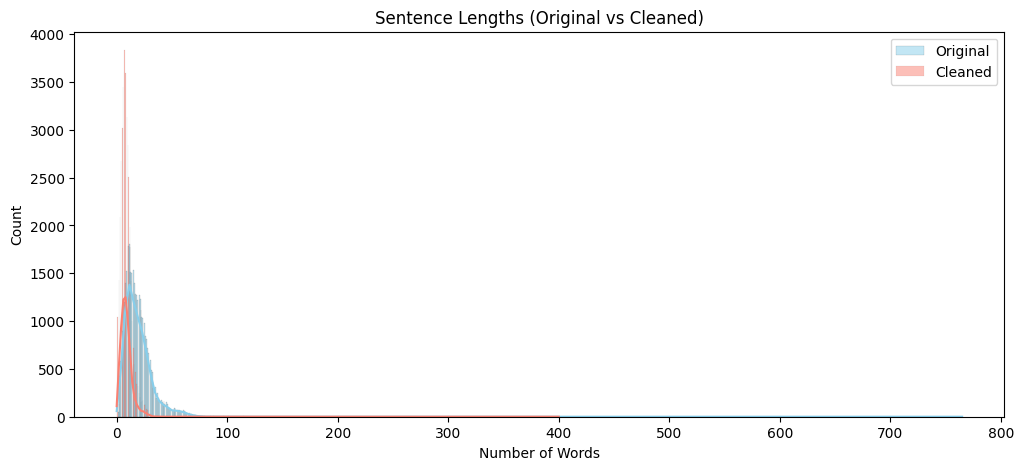

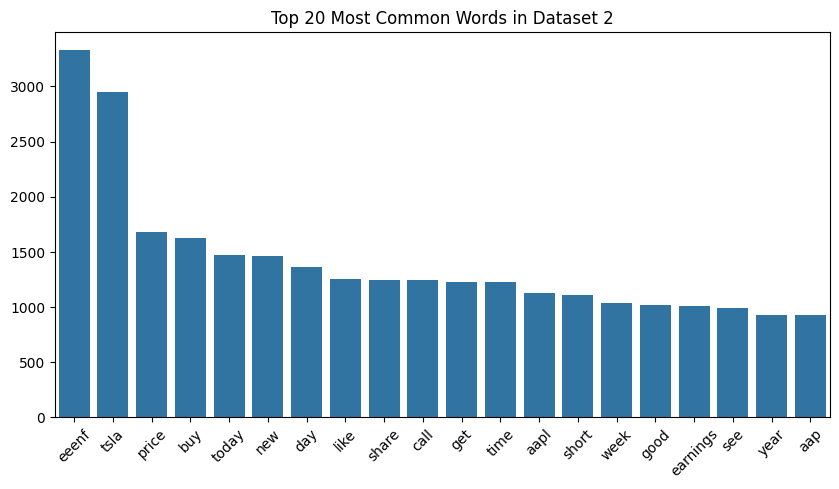

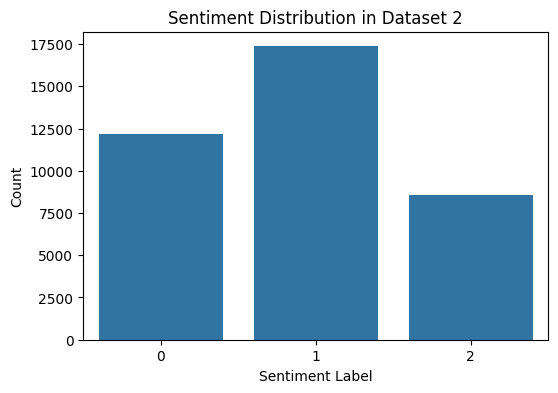

In [12]:
data2['Original_Length'] = data2['Sentence'].apply(lambda x: len(word_tokenize(x)))
data2['Cleaned_Length'] = data2['Cleaned'].apply(lambda x: len(word_tokenize(x)))

# Plot sentence lengths
plt.figure(figsize=(12, 5))
sns.histplot(data2['Original_Length'], kde=True, color='skyblue', label='Original')
sns.histplot(data2['Cleaned_Length'], kde=True, color='salmon', label='Cleaned')
plt.title("Sentence Lengths (Original vs Cleaned)")
plt.xlabel("Number of Words")
plt.legend()
plt.show()

# Plot most common words
all_words = ' '.join(data2['Cleaned']).split()
word_freq = Counter(all_words).most_common(20)

plt.figure(figsize=(10, 5))
sns.barplot(x=[w[0] for w in word_freq], y=[w[1] for w in word_freq])
plt.title("Top 20 Most Common Words in Dataset 2")
plt.xticks(rotation=45)
plt.show()

# Sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Sentiment', data=data2)
plt.title("Sentiment Distribution in Dataset 2")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()


# merge datasets


Before merging - Label distributions:
Dataset 1: ['positive' 'negative' 'neutral']
Dataset 2: [2 1 0]

After numeric conversion:
Dataset 1 numeric labels: [np.int64(-1), np.int64(0), np.int64(1)]
Dataset 2 numeric labels: [np.int64(-1), np.int64(0), np.int64(1)]

Combined dataset label distribution:
Sentiment
 0    20498
-1    13041
 1    10394
Name: count, dtype: int64


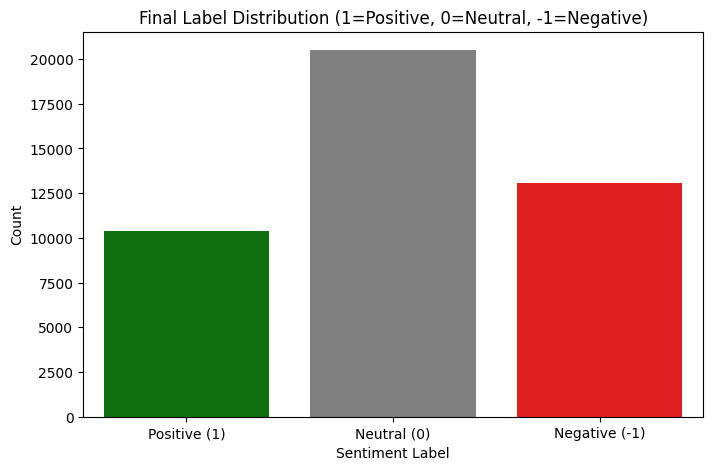


Datasets successfully merged! Final shape: (43933, 3)
Sample of merged data:
                                                Sentence  \
9935   After $550 Million Exit, 34-Year Old Founder W...   
3971   Costco: A Premier Retail Dividend Play https:/...   
737    $AMRN It's accumulating. I think buy now or ho...   
38913    @StockMKTNewz U missed one!!\n\n$EEENF 📈\n💨💨💨💨🚀   
10727  Navy Secretary Fired Over SEAL Controversy htt...   

                                                 Cleaned Sentiment  
9935       550 million exit old founder win fresh backer        -1  
3971            costco premier retail dividend play cost         1  
737    amrn accumulating think buy hold peace todayto...         1  
38913                                   missed one eeenf         0  
10727              navy secretary fired seal controversy        -1  


In [9]:
print("\nBefore merging - Label distributions:")
print("Dataset 1:", data1['Sentiment'].unique())
print("Dataset 2:", data2['Sentiment'].unique())

data1['Sentiment_numeric'] = data1['Sentiment'].map({
    'positive': 1,
    'neutral': 0,
    'negative': -1
})

data2['Sentiment_numeric'] = data2['Sentiment'].map({
    2: 1,    # positive
    1: 0,    # neutral
    0: -1    # negative
})

print("\nAfter numeric conversion:")
print("Dataset 1 numeric labels:", sorted(data1['Sentiment_numeric'].unique()))
print("Dataset 2 numeric labels:", sorted(data2['Sentiment_numeric'].unique()))

combined_data = pd.concat([
    data1[['Sentence', 'Cleaned', 'Sentiment_numeric']],
    data2[['Sentence', 'Cleaned', 'Sentiment_numeric']]
], axis=0).reset_index(drop=True)

combined_data = combined_data.rename(columns={'Sentiment_numeric': 'Sentiment'})

combined_data['Sentiment'] = combined_data['Sentiment'].astype('category')

print("\nCombined dataset label distribution:")
print(combined_data['Sentiment'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment',
             data=combined_data,
             order=[1, 0, -1],
             palette={1: 'green', 0: 'gray', -1: 'red'},
             hue='Sentiment',
             legend=False)
plt.title("Final Label Distribution (1=Positive, 0=Neutral, -1=Negative)")
plt.xticks([0, 1, 2], ['Positive (1)', 'Neutral (0)', 'Negative (-1)'])
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()

# Save to CSV
combined_data.to_csv('combined_financial_sentiment_numeric.csv', index=False)
print("\nDatasets successfully merged! Final shape:", combined_data.shape)
print("Sample of merged data:")
print(combined_data.sample(5))

In [10]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

samples = combined_data.sample(5, random_state=42)[['Sentence', 'Cleaned', 'Sentiment']].copy()

sentiment_map = {-1: 'NEGATIVE', 0: 'NEUTRAL', 1: 'POSITIVE'}
samples['Sentiment_Text'] = samples['Sentiment'].map(sentiment_map)

for idx, row in samples.iterrows():
    print(f"\nSAMPLE {idx}:")
    print(f"ORIGINAL: {row['Sentence']}")
    print(f"CLEANED: {row['Cleaned']}")
    print(f"LABEL: {row['Sentiment']} ({row['Sentiment_Text']})")
    print("-"*80)

pd.reset_option('display.max_colwidth')
pd.reset_option('display.width')


SAMPLE 18664:
ORIGINAL: CEG Confirming the expectation below 98.50.  ikely to crack here.
CLEANED: ceg confirming expectation ikely crack
LABEL: 1 (POSITIVE)
--------------------------------------------------------------------------------

SAMPLE 26893:
ORIGINAL: $TWTR just a glimpse of the deal falling apart will send this down like a meteor. The risk reward is not in the longs favor. But to each his own I guess. 👁 #stockmarket
CLEANED: twtr glimpse deal falling apart send like meteor risk reward longs favor guess stockmarket
LABEL: 1 (POSITIVE)
--------------------------------------------------------------------------------

SAMPLE 16739:
ORIGINAL: TicToc https://t.co/EOsKuYWXOv tarafından ⚡️ “Iman, the last Sumatran rhinoceros in Malaysia, has died at 25”
CLEANED: tictoc tarafından iman last sumatran rhinoceros malaysia died
LABEL: -1 (NEGATIVE)
--------------------------------------------------------------------------------

SAMPLE 12272:
ORIGINAL: Wheat Futures Jump as Virus-Stri

## Downloading Merged Dataset

In [11]:
from google.colab import files

def download_merged_data():
    combined_data.to_csv('financial_sentiment_merged.csv', index=False)
    files.download('financial_sentiment_merged.csv')
    print("Download initiated!")

print("\nTo download manually, call: download_merged_data()")

download_merged_data()


To download manually, call: download_merged_data()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated!
